In [1]:
# PyTorch
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.utils import make_grid

# Data manipulations
import numpy as np
from PIL import Image
import cv2
import pandas as pd
from skimage import io, transform
import matplotlib.pyplot as plt

# helpers
import glob
import os
import copy
import time
import csv

# dataloader
from data_loader import ApplyClaheColor
from data_loader import Denoise
from data_loader import Resize
from data_loader import ToTensor
from data_loader import Normalize
from data_loader import SegmentationDataset

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

from Model.segnet import SegNet

img_ch=3
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SegNet(num_classes=1)
model.to(device)

data_dir = 'Training Data/training_data' 

In [2]:
""" Full assembly of the parts to form the complete network """

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

        return out


I have prepared several transformations to be applied on the images. I've used random flip as augmentation technique. I am also using CLAHE (Contrast Limiting Adaptive Histogram Equalization) nad Bilateral filter to improve the quality of images: CLAHE preforms histogram equalization in a smart way. I included Bilateral filter because I've noticed that after CLAHE the pictures are a little bit noisy. I decided to use bilateral filter instead of median filter because it keeps the edges sharp, what is crucial in segmentation task.

In [3]:

def get_data_loaders(data_dir, image_folder='training_data/img', mask_folder='training_data/label', batch_size=4):
    
    data_transforms = {
        'training': transforms.Compose([ApplyClaheColor(), Denoise(), Resize((320, 320), (320, 320)), ToTensor(), Normalize()]),
        'test': transforms.Compose([ApplyClaheColor(), Denoise(), Resize((320, 320), (320, 320)),ToTensor(), Normalize()]),
    }
    
    image_datasets = {x: SegmentationDataset(root_dir=data_dir,
                                             transform=data_transforms[x],
                                             image_folder=image_folder,
                                             mask_folder=mask_folder,
                                             subset=x)
                      for x in ['training', 'test']}
    
    data_loaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0)
                    for x in ['training', 'test']}
    
    return data_loaders


def plot_batch_from_dataloader(dataloaders, batch_size):
    """

    :param dataloaders: dataset dataloaders
    :param batch_size: size of the batch to plot
    :return: void
    """
    batch = next(iter(dataloaders['training']))

    for i in range(batch_size):

        np_img = batch['image'][i].numpy()
        np_mask = batch['mask'][i].numpy()

        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(np.transpose(np_img, (1, 2, 0)))
        ax[1].imshow(np.squeeze(np.transpose(np_mask, (1, 2, 0))), cmap='gray')
        plt.show()


def myimshow(img, unnormalize=False):
    """

    :param img: tensor of images, first dimension is number of images in the batch
    :param unnormalize: whenever to unnormalize the image before plotting
    :return: void
    """
    if unnormalize:
        img = img * 255

    np_img = img.numpy()
    plt.imshow(np.transpose(np_img[0], (1, 2, 0)))
    plt.show()


def images_generator(path):
    for img_name in glob.glob(os.path.join(path, '*')):
        image = np.array(Image.open(img_name)).transpose(2, 0, 1)
        yield image

D:\Dropbox\Project_Ongoing\511 CCTV Camera Network


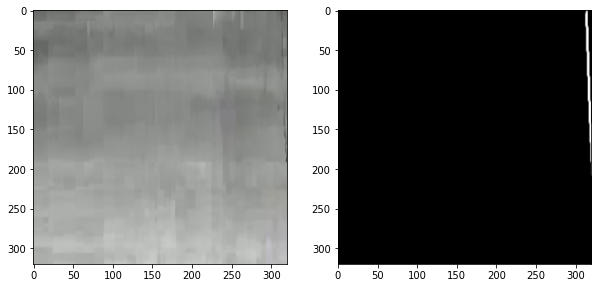

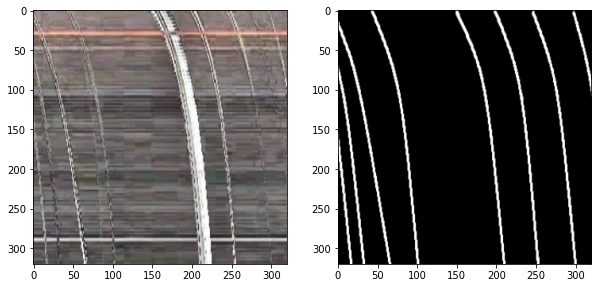

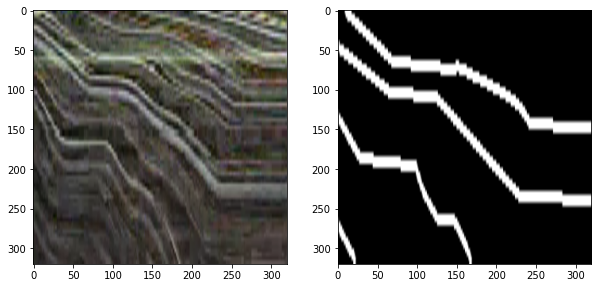

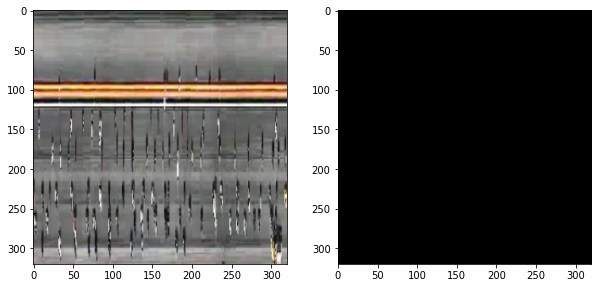

In [4]:
data_dir = os.getcwd()
print(data_dir)
dataloaders = get_data_loaders(data_dir, batch_size=4)
plot_batch_from_dataloader(dataloaders, 4)

In [5]:
from sklearn.metrics import jaccard_score, precision_score, recall_score

def accuracy(y_true, y_pred):
    
    mask = np.zeros_like(y_pred)
    mask[y_pred >= 0.5] = 1

    compare = np.equal(mask, y_true)
    accuracy = np.sum(compare)

    return accuracy/len(y_pred.flatten())

def IoU(y_true, y_pred):
    # jaccard_score
    
    mask = np.zeros_like(prediction)
    mask[prediction >= 0.5] = 1
    
    return jaccard_score(y_true, mask, average='samples')


def precision_and_recall(label_gt, label_pred, n_class):

    assert len(label_gt) == len(label_pred)
    precision = np.zeros(n_class, dtype=np.float32)
    recall = np.zeros(n_class, dtype=np.float32)
    img_A = np.array(label_gt, dtype=np.float32).flatten()
    img_B = np.array(label_pred, dtype=np.float32).flatten()
    precision[:] = precision_score(img_A, img_B, average=None, labels=range(n_class))
    recall[:] = recall_score(img_A, img_B, average=None, labels=range(n_class))

    return precision, recall
    
    
def dice_coeff(prediction, target):

    mask = np.zeros_like(prediction)
    mask[prediction >= 0.5] = 1

    inter = np.sum(mask * target)
    union = np.sum(mask) + np.sum(target)
    epsilon=1e-6
    result = np.mean(2 * inter / (union + epsilon))
    return result


class FocalLoss(nn.modules.loss._WeightedLoss):

    def __init__(self, gamma=0, size_average=None, ignore_index=-100,
                 reduce=None, balance_param=1.0):
        super(FocalLoss, self).__init__(size_average)
        self.gamma = gamma
        self.size_average = size_average
        self.ignore_index = ignore_index
        self.balance_param = balance_param

    def forward(self, input, target):
        
        # inputs and targets are assumed to be BatchxClasses
        assert len(input.shape) == len(target.shape)
        assert input.size(0) == target.size(0)
        assert input.size(1) == target.size(1)
           
        # compute the negative likelyhood
        logpt = - F.binary_cross_entropy_with_logits(input, target)
        pt = torch.exp(logpt)

        # compute the loss
        focal_loss = -( (1-pt)**self.gamma ) * logpt
        balanced_focal_loss = self.balance_param * focal_loss
        return balanced_focal_loss


There is quite some code needed to got everything working. In the training loop I'am tracking loss in each batch for each epoch, and save it for plotting the learning curve.

In [8]:
## Model Training

## Load Model ##

since = time.time()
best_loss = 1e10
save_frq = 4000
ite_num = 0.0

## set up parameters ##
batch_size = 3
num_epochs = 80
Learning_Rate=1e-5
Weight_Decay=1e-4 # Weight for the weight decay loss function
MAX_ITERATION = int(800010) # Max  number of training iteration
NUM_CLASSES = 1 #Number of classes the model predict

dataloaders = get_data_loaders(data_dir, batch_size=batch_size)
optimizer=torch.optim.Adam(params=model.parameters(),lr=Learning_Rate,weight_decay=Weight_Decay)
criterion = FocalLoss(gamma=2)

# Use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

fieldnames = ['epoch', 'training_loss', 'test_loss', 'training_acc', 'test_acc', 'training_dice_coeff', 'test_dice_coeff']
train_epoch_losses = []
test_epoch_losses = []

train_epoch_accs = []
test_epoch_accs = []

saved_model_folder = os.path.join(os.getcwd(), 'saved_models')

if not os.path.exists(saved_model_folder):
    os.makedirs(saved_model_folder)

for epoch in range(1, num_epochs + 1):

    print(f'Epoch {epoch}/{num_epochs}')
    print('-' * 10)
    # Each epoch has a training and validation phase
    # Initialize batch summary
    batchsummary = {a: [0] for a in fieldnames}
    batch_train_loss = 0.0
    batch_test_loss = 0.0

    batch_train_correct = 0.0
    batch_test_correct = 0.0
    
    with open(('log_SegNet.csv'), 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
    

    for phase in ['training', 'test']:
        if phase == 'training':
            model.train()  # Set model to training mode
        else:
            model.eval()  # Set model to evaluate mode

        # Iterate over data.
        for sample in iter(dataloaders[phase]):

            ite_num = ite_num + 1

            inputs = sample['image'].to(device)
            masks = sample['mask'].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # track history only in training phase
            with torch.set_grad_enabled(phase == 'training'):
                outputs = model(inputs)

                loss = criterion(outputs, masks)

                y_pred = outputs.data.cpu().numpy().ravel()
                y_true = masks.data.cpu().numpy().ravel()

                dice_score = dice_coeff(y_pred, y_true)

                batchsummary[f'{phase}_dice_coeff'].append(dice_coeff(y_pred, y_true))

                if ite_num % save_frq == 0:

                    torch.save(model.state_dict(), saved_model_folder + "DAIU "+"_bce_itr_%d_train_%3f.pth" 
                               % (ite_num, dice_score,))
                    model.train()  # resume train

                # back-propagation
                if phase == 'training':
                    loss.backward()
                    optimizer.step()

                    # accumulate batch loss
                    batch_train_loss += loss.item() * sample['image'].size(0)
                    batch_train_correct += accuracy(y_true.astype('uint8'), y_pred)

                else:
                    batch_test_loss += loss.item() * sample['image'].size(0)
                    batch_test_correct += accuracy(y_true.astype('uint8'), y_pred)

        # save epoch losses
        if phase == 'training':
            epoch_train_loss = batch_train_loss / len(dataloaders['training'])
            batchsummary[f'{phase}_loss'] = epoch_train_loss

            epoch_train_acc = batch_train_correct/ len(dataloaders['training'])
            batchsummary[f'{phase}_acc'] = epoch_train_acc
            

            
        else:
            epoch_test_loss = batch_test_loss / len(dataloaders['test'])
            batchsummary[f'{phase}_loss'] = epoch_test_loss

            test_epoch_acc = batch_test_correct / len(dataloaders['test'])
            batchsummary[f'{phase}_acc'] = test_epoch_acc
            

        batchsummary['epoch'] = epoch
        
        print('{} Loss: {:.4f}'.format(phase, loss))

    best_loss = np.max(batchsummary['test_dice_coeff'])
    
    for field in fieldnames[3:]:
        batchsummary[field] = np.mean(batchsummary[field])
        
    with open(('log_SegNet.csv'), 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writerow(batchsummary)
        
    print(
        f'\t\t\t train_dice_coeff: {batchsummary["training_dice_coeff"]}, test_dice_coeff: {batchsummary["test_dice_coeff"]}')

# summary
print('Best dice coefficient: {:4f}'.format(best_loss))


Epoch 1/80
----------
100 iteration



AttributeError: 'float' object has no attribute 'item'

Let's take a look at the images and their correspodning masks

After trying a few values of learning rate and number of epochs I've dicided to use following values:

We can see that the model converges nicely. I plotted the loss starting from 20th epoch, because at the very beginning of the training it jumped that much, so one could not see what was happening next - the plot was almost flat

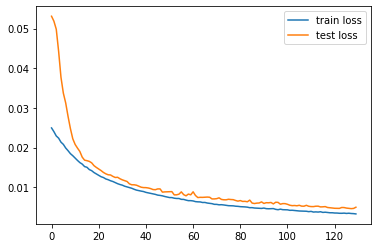

In [28]:
train_plot, = plt.plot(range(len(train_epoch_losses)-20), train_epoch_losses[20:], label='train loss')
test_plot, = plt.plot(range(len(test_epoch_losses)-20), test_epoch_losses[20:], label='test loss')
plt.legend(handles=[train_plot, test_plot])
plt.show()

In [ ]:
train_plot, = plt.plot(range(len(train_epoch_accs)-20), train_epoch_accs[20:], label='train accuracy')
test_plot, = plt.plot(range(len(test_epoch__accs)-20), test_epoch_losses[20:], label='test accuracy')
plt.legend(handles=[train_plot, test_plot])
plt.show()

We can plot the predictions to make sure the model learned what we expect

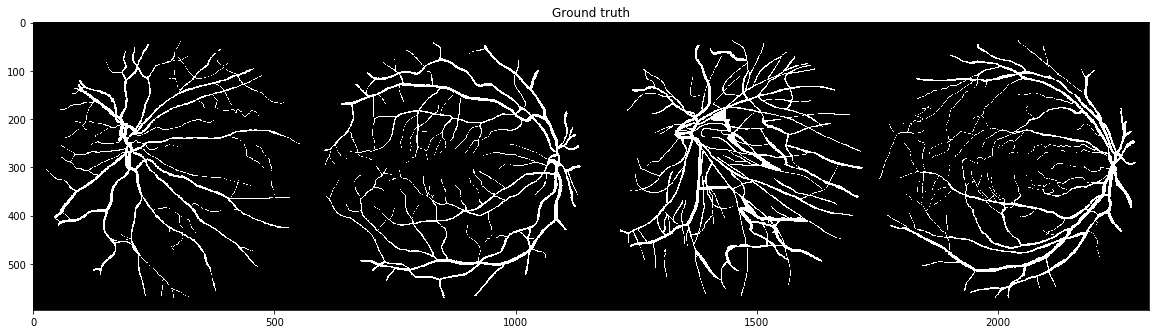

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


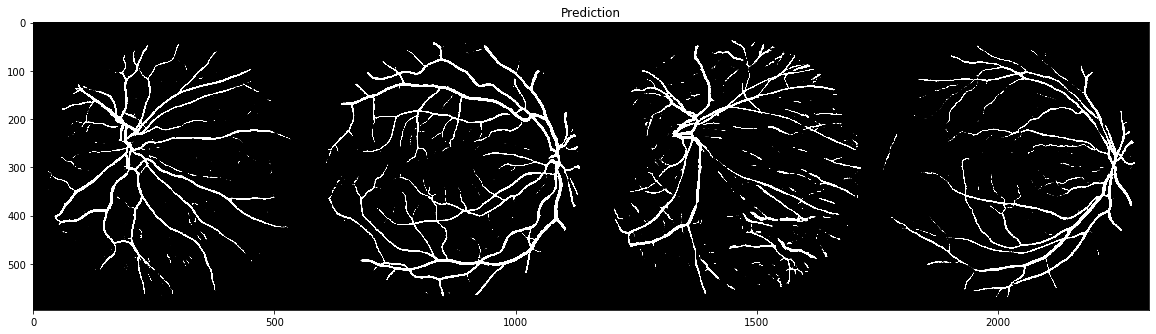

In [29]:
dataiter = iter(dataloaders['test'])
batch = dataiter.next()

f = plt.figure(figsize=(20, 20))
grid_img = make_grid(batch['mask'])
grid_img = grid_img.permute(1, 2, 0)
plt.imshow(grid_img)
plt.title('Ground truth')
plt.show()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
trained_model.to(device)
inputs = batch['image'].to(device)
prediction = trained_model(inputs).detach().cpu()

prediction[prediction >= 0.5] = 1

f = plt.figure(figsize=(20, 20))
grid_img = make_grid(prediction)
grid_img = grid_img.permute(1, 2, 0)
plt.imshow(grid_img)
plt.title('Prediction')
plt.show()